# Assignment 1d Notebook: Multi-Objective EA
This notebook is the final notebook in assignment series 1 and further iterates on the progress you've made so far. This notebook will guide you through a novel implementation of a multi-objective EA (MOEA) that utilizes the EA framework you've been implementing since Assignment 1b as much as possible. Similar to the previous assignments, you should copy over the following files:
* 1a_notebook.ipynb
* 1b_notebook.ipynb
* 1c_notebook0.ipynb
* 1c_notebook1.ipynb
* baseEvolution.py
* binaryGenotype.py
* selection.py
* selfAdaptiveEvolution.py
* selfAdaptiveGenotype.py


*Be careful* to not copy over functions relating to the provided fitness functions, GPac, and static agents. We have updated `fitness.py` for this assignment, so be particularly careful not to accidentally copy the old version from Assignment 1c.

As usual, be sure to **read all of this notebook** and you can start by executing the next cell.

In [1]:
# Configure this notebook to automatically reload modules as they're modified
# https://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (12.0, 12.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# define utility plotting function
def plotMap(maze, mazeNumber):
    '''A so-so map plotting function'''
    pltmaze = [[None for __ in range(len(maze))] for _ in range(len(maze[0]))]
    for y in range(len(maze[0])):
        for x in range(len(maze)):
            pltmaze[y][x] = 0 if maze[x][y]==1 else 1
    plt.matshow(pltmaze, origin='lower')
    plt.xticks(range(len(pltmaze[0])))
    plt.yticks(range(len(pltmaze)))
    plt.gca().set_xticks([x - 0.5 for x in plt.gca().get_xticks()][1:], minor='true')
    plt.gca().set_yticks([y - 0.5 for y in plt.gca().get_yticks()][1:], minor='true')
    plt.grid(which='minor')
    plt.savefig('data/ParetoMaze' + str(mazeNumber) + '.jpg')
    plt.show()

print('The first cell has been executed!')

The first cell has been executed!


## Multi-Objective Fitness Evaluations
In a traditional MOEA implementation like the Non-dominated Sorting Genetic Algorithm II [(NSGA-II)](https://ieeexplore.ieee.org/abstract/document/996017?casa_token=sIy9DHU74qAAAAAA:f9M0Nu6WrHIswdRILFlqhxUqW-rK1nfke65Xw88A1JNX5TaaXZAL76yrC3L8WncdUlrDi25Y7Zo), individuals in a population are assessed by multiple objectives, assigned a score for each objective, and are then sorted into levels of non-domination (more on that later) during parent and survival selection. In a traditional MOEA implementation, you might write a multi-objective version of k-tournament that samples k individuals from the population and selects the winner as the individual who is on the Pareto front from those k individuals. This formulation thus doesn't use a single-value notion of fitness as your existing k-tournament implementations do.

To enable the re-use of your existing selection algorithms, we propose a novel MOEA implementation that assigns individuals in a population a singular fitness value based on their level of non-domination. This behaves in a functionally equivalent manner in the rank-based selection algorithms used in traditional MOEA implementations. This also lets you use non-traditional selection algorithms like Fitness Proportional Selection in your MOEA, though they may perform poorly.

In your MOEA for this assignment, you will do the following:
* Evaluate new members in a population to assign objective scores
* Construct a domination table for *all* individuals in the population
* Sort the population into levels of non-domination where level 0 is the Pareto front
* To each individual in the population, assign a representative fitness that is inversely proportional to their level of non-domination 
 - i.e., `num_levels - my_level`

To accomplish this, you'll implement three functions:
1. `evaluate_popluation` - which assigns objective score to new population members after generation
2. `dominates` - which takes individuals `A` and `B` as  inputs and returns `True` if `A` dominates `B`
3. `non_domination_sort` - which sorts the population into levels of non-domination and assigns a representative fitness.

First, let's start by showing an example of the multi-objective fitness function.

The solution's objective scores are [-130.2, -31] and the game log was written to worldFiles/1dnotebooktest.txt
The solution map looks like this:


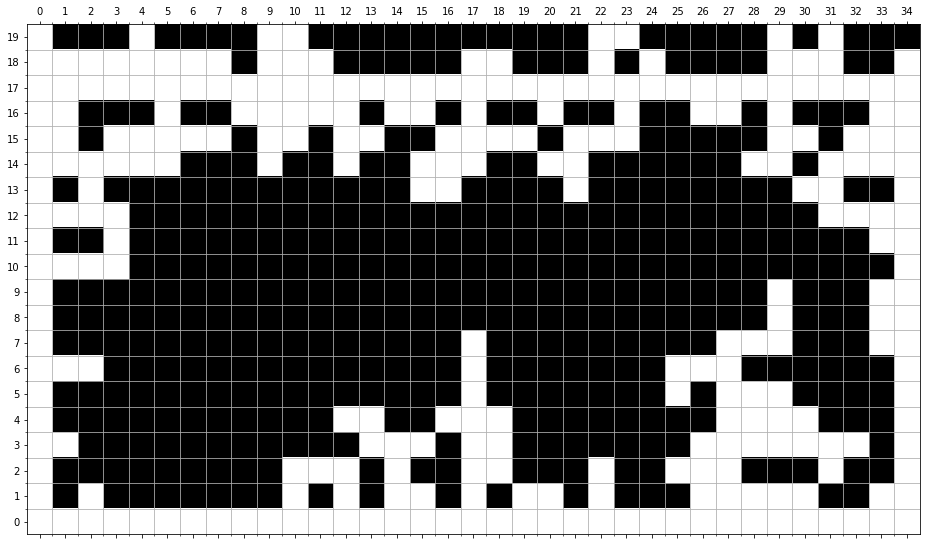

In [2]:
from selection import *
from snakeeyes import readConfig
from binaryGenotype import binaryGenotype
from fitness import repair_and_test_map, translate_gene, repair_map

config = readConfig('./configs/green1d_config.txt', globalVars=globals(), localVars=locals())

testSolution = binaryGenotype()
testSolution.randomInitialization(**config['initialization_kwargs'])

testSolution.objectives, testSolution.log = repair_and_test_map(testSolution.gene, **config['fitness_kwargs'])
# testSolution.rawFitness = testSolution.objectives[0]

game_log_path = 'worldFiles/1dnotebooktest.txt'
with open(game_log_path, 'w') as f:
	[f.write(f'{line}\n') for line in testSolution.log]
    
print(f"The solution's objective scores are {testSolution.objectives} and the game log was written to {game_log_path}")
print('The solution map looks like this:')
repaired_map, _ = repair_map(translate_gene(testSolution.gene, config['fitness_kwargs']['height'], config['fitness_kwargs']['width']))
plotMap(repaired_map, 1)

del testSolution # to prevent haphazard copypasta

Notice that this time the `repair_and_test_map` function returned a list of values instead of a single value. The first value is negative average pac-man score like the previous assignments. The second value is the negative of the count of cells on the map surrounded by 3 walls (aka the negative count of dead ends). We want to maximize both of these objectives and assume that they are conflicting objectives since dead ends make great traps for pac-man. The number of dead ends should match with the visualization generated above.

Note: `repair_and_test_map` returns a list here because the config file defines the fitness keyword argument `minimize_dead_ends = True`.

Now that you've seen an example of calling the fitness function in a new way, write an `evaluate_population` function that takes as input a population and fitness_kwargs dictionary and populates the `objectives` and `log` member variables of all individuals in the population.

In [3]:
# evaluate the population and assign objectives and logs as described above
def evaluate_population(population, fitness_kwargs):
    if fitness_kwargs.get('return_repair_count') != True:
        for individual in population:
            individual.objectives, individual.log = repair_and_test_map(individual.gene, **config['fitness_kwargs'])
        pass
    else:
        #RED deliverable logic goes here (if attempted)
        pass

In [4]:
import statistics

examplePopulation = binaryGenotype.initialization(10, **config['initialization_kwargs'])
for individual in examplePopulation:
    individual.objectives = None

# calling your function to test things out
evaluate_population(examplePopulation, config['fitness_kwargs'])
print(f'Individuals with unassigned objectives: {len([individual.objectives for individual in examplePopulation if individual.objectives is None])}')
print(f'Number of fitness evaluations performed: {len([individual.objectives for individual in examplePopulation if individual.objectives is not None])}')
if config['fitness_kwargs'].get('minimize_dead_ends') == True:
    print(f'Average value of pac-man score objective: {statistics.mean([individual.objectives[0] for individual in examplePopulation])}')
    print(f'Average value of dead end objective: {statistics.mean([individual.objectives[1] for individual in examplePopulation])}')

del examplePopulation

Individuals with unassigned objectives: 0
Number of fitness evaluations performed: 10
Average value of pac-man score objective: -119.17999999999999
Average value of dead end objective: -38.2


## Multi-Objective Domination
As discussed in the course lectures, a prevalent way to assess solutions in an MOEA is to determine whether or not a solution *dominates* another solution in the population. Recall from the lecture that an individual `A` is said to dominate an individual `B` if and only if:
* `A` is no worse than `B` in all objectives *AND*
* `A` is strictly better than `B` in at least one objective

In the next cell, implement the function `dominates` that compares the `objectives` member variables of the input individuals returns `True` if `A` dominates `B` and `False` otherwise.

In [5]:
# compare the individuals as described above
def dominates(A, B):
    strictlyBetterCount = 0
    for i in range(len(A.objectives)):
        if(A.objectives[i] < B.objectives[i]):
            return False
        elif (A.objectives[i] > B.objectives[i]):
            strictlyBetterCount += 1
    return (strictlyBetterCount >= 1)
    pass

To evaluate your implementation of the `dominates` function, we're going to compare against the model answer from Question 11 of the second exam from Fall 2020 [(link here)](http://bonsai.auburn.edu/dtauritz/courses/ec/intro/2020fall/IntroECfs2020exam2key.pdf). The output generated by executing the following cell should match the domination table from part (a) of that problem.

In [6]:
objectiveScores = [[8,2],
                   [4,1],
                   [2,3],
                   [1,2],
                   [9,1],
                   [4,7],
                   [2,5],
                   [1,3],
                   [10,7],
                   [5,5]]
expectation = [[2, 4],
              [],
              [4,8],
              [],
              [2],
              [2,3,4,7,8],
              [3,4,8],
              [4],
              [1,2,3,4,5,6,7,8,10],
              [2,3,4,7,8]]

examPopulation = binaryGenotype.initialization(len(objectiveScores), **config['initialization_kwargs'])

# assigning objectives this way for demo purposes only
for idx in range(len(objectiveScores)):
    examPopulation[idx].objectives = objectiveScores[idx]

print('ID\t Dominates')

# Note that this implementation of a domination table has some quirks so it matches the exam.
# Advise caution if you copy this code later because you should probably modify it.
for idx in range(len(examPopulation)):
    dominationList = list()
    for opponentIdx in range(len(examPopulation)):
        if idx == opponentIdx:
            continue
        if dominates(examPopulation[idx], examPopulation[opponentIdx]):
            dominationList.append(opponentIdx+1)
    print(f'{idx+1}\t{dominationList}', end='')
    if dominationList != expectation[idx]:
        print(f'\texpected {expectation[idx]}')
    else:
        print()
del examPopulation
del expectation

ID	 Dominates
1	[2, 4]
2	[]
3	[4, 8]
4	[]
5	[2]
6	[2, 3, 4, 7, 8]
7	[3, 4, 8]
8	[4]
9	[1, 2, 3, 4, 5, 6, 7, 8, 10]
10	[2, 3, 4, 7, 8]


## Non-domination Sort
With the `dominates` function implemented, you can now implement the `non_domination_sort` function. This function takes as input a population and has three main steps:
1. Calculate a domination lookup table (this is technically optional but provides a drastic speedup)
2. Sort individuals into levels of non-domination with the algorithm performed in class and where level 0 is the Pareto front
3. Assign each individual a representative fitness to their `fitness` member variable equal to the number of non-domination levels minus the level of the individual

Note: you may implement additional helper functions to call within `non-domination_sort` so long as calling the `non_domination_sort` function produces the expected results.

In [7]:
def createDominationMatrix(population, returnFirstFrontAndDominatedCounts = False):
    domMatrix = []
    frontOne = []
    dominatedCounts = []
    for idx in range(len(population)):
        dominationList = list()
        dominatedCount = 0
        for opponentIdx in range(len(population)):
            if idx == opponentIdx:
                continue
            if dominates(population[idx], population[opponentIdx]):
                dominationList.append(opponentIdx)
            elif dominates(population[opponentIdx], population[idx]):
                dominatedCount += 1
        if(dominatedCount == 0):
            frontOne.append(idx)
        domMatrix.append(dominationList)
        dominatedCounts.append(dominatedCount)
    if(returnFirstFrontAndDominatedCounts):
        return domMatrix, frontOne, dominatedCounts
    else:
        return domMatrix

In [8]:
def non_domination_sort(population, crowding=False, **kwargs):
    # calculate domination table
    fronts = []
    domMatrix, frontOne, dominatedCounts = createDominationMatrix(population, returnFirstFrontAndDominatedCounts = True)
    fronts.append(frontOne)
    frontCounter = 0 
    
    # sort into levels of non-domination
    while len(fronts[frontCounter]) > 0:
        nextFront = []
        for idx in fronts[frontCounter]:
            for dominatedIdx in domMatrix[idx]:
                dominatedCounts[dominatedIdx] -= 1
                if(dominatedCounts[dominatedIdx] == 0):
                    nextFront.append(dominatedIdx)
        frontCounter += 1
        fronts.append(nextFront)
    
    # calculate representative fitness
    if crowding==False:
        frontCount = len(fronts)
        for frontIdx in range(frontCount):
            for idx in fronts[frontIdx]:
                population[idx].fitness = frontCount - frontIdx
        # return pareto front
            
    else:
        # YELLOW deliverable code for crowding goes here
        pass

We'll evaluate your `non_domination_sort` implementation using the same exam question we used to evaluate `dominates`. As such, your algorithm should generate `fitness` values that describe a non-domination sort with a similar result to that in the model answer.

In [9]:
config = readConfig('./configs/green1d_config.txt', globalVars=globals(), localVars=locals())

examPopulation = binaryGenotype.initialization(len(objectiveScores), **config['initialization_kwargs'])

# assigning objectives this way for demo purposes only
for idx in range(len(objectiveScores)):
    examPopulation[idx].objectives = objectiveScores[idx]

# calling your function to test it out
non_domination_sort(examPopulation, **config['EA_configs'])

print(f'Individuals with unassigned fitness: {len([individual.fitness for individual in examPopulation if individual.fitness is None])}')
print(f'Number of fitness evaluations performed: {len([individual.fitness for individual in examPopulation if individual.fitness is not None])}')

fitnesses = set()

for individual in examPopulation:
    if individual.fitness is not None:
        # truncate the fitness values in case you've implemented the YELLOW deliverable
        individual.fitness = int(individual.fitness)
    fitnesses.add(individual.fitness)

fitnesses = sorted(list(fitnesses), reverse=True)
print('\nLevels of non-domination after adding all elements')
for levelIdx in range(len(fitnesses)):
    print(f'level {levelIdx}: {sorted([ind+1 for ind in range(len(examPopulation)) if examPopulation[ind].fitness == fitnesses[levelIdx]])}')

del examPopulation

Individuals with unassigned fitness: 0
Number of fitness evaluations performed: 10

Levels of non-domination after adding all elements
level 0: [9]
level 1: [1, 5, 6, 10]
level 2: [2, 7]
level 3: [3]
level 4: [8]
level 5: [4]


## Assembling the MOEA
Now that you have `evaluate_fitness`, `dominates`, and `non_domination_sort` functions implemented, you can assemble your complete MOEA using the `baseEvolutionPopulation` population class you implemented in Assignment 1b. There are, however, some small differences from a single-objective EA that we'll walk you through in the following example.

In [10]:
from baseEvolution import baseEvolutionPopulation

config = readConfig('./configs/green1d_config.txt', globalVars=globals(), localVars=locals())

# full initialization of your EA
exampleEA = baseEvolutionPopulation(**config['EA_configs'], **config)
evaluate_population(exampleEA.population, config['fitness_kwargs'])

# evaluate initial population
exampleEA.evaluations = len(exampleEA.population)
print(f'Number of fitness evaluations: {exampleEA.evaluations}')

Number of fitness evaluations: 200


Until this point, the EA has gone as expected. We've read a config, initialized the EA, and evaluated the initial population. Recall, however, that the fitness evaluation only assigns objective scores that can't directly be used as single-value fitness in evolution. To calculate a single fitness value and evolve as usual, we have to add a call to the new `non_domination_sort` before entering child generation (and parent selection).

In [11]:
# sort population and assign representative fitness
non_domination_sort(exampleEA.population)

Once `non_domination_sort` has been called, the EA can generate children. Once the children are evaluated for objective scores and have been added to the population, we need to re-sort the population and re-calculate representative fitness before entering survival selection. As a rule of thumb, you'll need to re-calculate representative fitness using `non_domination_sort` before each function call that utilizes a selection algorithm.

In [12]:
# generate children
config = readConfig('./configs/green1d_config.txt', globalVars=globals(), localVars=locals())
children = exampleEA.generate_children()
evaluate_population(children, config['fitness_kwargs'])
exampleEA.evaluations += len(children)
print(f'Number of fitness evaluations: {exampleEA.evaluations}')
# re-sort modified population and assign representative fitness
non_domination_sort(exampleEA.population)

# perform survival selection
exampleEA.survival()

Number of fitness evaluations: 300


The calls to `non_domination_sort` are new additions to the EA cycle, but otherwise the MOEA cycle closely resembles that of previous assignments.

Now that you've implemented the necessary functions and the MOEA cycle has been demonstrated, implement a single run of your MOEA that searches for 2,000 fitness evaluations.

In [13]:

def compareParetoFronts(frontOne, frontTwo):
    if(len(frontTwo) == 0):
        return True
    frontOneAtleastOneDominationList = [0 for i in range(len(frontOne))]
    frontTwoAtleastOneDominationList = [0 for i in range(len(frontTwo))]
    for idx in range(len(frontOne)):
        dominationList = list()
        dominatedCount = 0
        for opponentIdx in range(len(frontTwo)):
            if dominates(frontOne[idx], frontTwo[opponentIdx]):
                frontOneAtleastOneDominationList[idx] = 1
            elif dominates(frontTwo[opponentIdx], frontOne[idx]):
                frontTwoAtleastOneDominationList[opponentIdx] = 1
    return sum(frontOneAtleastOneDominationList) > sum(frontTwoAtleastOneDominationList)

In [141]:
number_evaluations = 2000
import time
from baseEvolution import baseEvolutionPopulation

# You can parse different configuration files here as necessary
config = readConfig('./configs/green1d_config.txt', globalVars=globals(), localVars=locals())
def appendAvgandMaxObjectives(population, avgObjectives, maxObjectives):
    for objectiveIdx in range(len(population[0].objectives)):
        objectiveList = [individual.objectives[objectiveIdx] for individual in population]
        avgObjectives[objectiveIdx].append(statistics.mean(objectiveList))
        maxObjectives[objectiveIdx].append(max(objectiveList))

# implement your EA here
def evolutionaryAlgorithm(config, numberOfEvaluations, runNumber):
    eaPopulation = baseEvolutionPopulation(**config['EA_configs'], **config)
    evaluate_population(eaPopulation.population, config['fitness_kwargs'])
    eaPopulation.evaluations = len(eaPopulation.population)
    non_domination_sort(eaPopulation.population)
    avgObjectives = [[] for objectiveIdx in range(len(eaPopulation.population[0].objectives))]
    maxObjectives = [[] for objectiveIdx in range(len(eaPopulation.population[0].objectives))]
    appendAvgandMaxObjectives(eaPopulation.population, avgObjectives, maxObjectives)
    bestParetoFront = [individual for individual in eaPopulation.population if individual.fitness == 0]
    evaluationsAtIteration = [0]
    while(eaPopulation.evaluations < numberOfEvaluations):
        non_domination_sort(eaPopulation.population)
        children = eaPopulation.generate_children()
        evaluate_population(children, config['fitness_kwargs'])
        eaPopulation.evaluations += len(children)
        eaPopulation.population += children
        non_domination_sort(eaPopulation.population)
        eaPopulation.survival()        
        evaluationsAtIteration.append(eaPopulation.evaluations)
        non_domination_sort(eaPopulation.population)
        appendAvgandMaxObjectives(eaPopulation.population, avgObjectives, maxObjectives)
        #those with the max fitness should be those in pareto front
        maxFitness = max([individual.fitness for individual in eaPopulation.population])
        newParetoFront = [individual for individual in eaPopulation.population if individual.fitness == maxFitness]
        if(compareParetoFronts(newParetoFront, bestParetoFront)):
            bestParetoFront = newParetoFront
    return {'eaPopulation' : eaPopulation, 'avgObjectives': avgObjectives,'maxObjectives' : maxObjectives, 'evaluationsAtIterations' : evaluationsAtIteration, 'bestParetoFront' : bestParetoFront}



Now that you've tested an implementation of a single run, implement code to perform 30 runs of your MOEA search that each contain 2,000 evaluations. For each generation of each run, log the mean and best values for all objectives in the current population as well as the number of fitness evaluations performed so far (including the initial population). Also for each run, record the objective scores and maps (either game logs or the genes) for all individuals in the Pareto front of the final generation. The maps and objective scores will be used for analysis in your report.

If you have attempted the YELLOW deliverable, you should record the diversity of the Pareto front from the final population of each run using a diversity metric of your choice.

In [144]:
number_runs = 30
number_evaluations = 2000

from multiprocessing import Pool
from functools import partial
# You can parse different configuration files here as necessary
config = readConfig('./configs/green1d_config.txt', globalVars=globals(), localVars=locals())

# implement your multi-run experiment here
if __name__ == '__main__':
    p = Pool(number_runs)
    partialEa = partial(evolutionaryAlgorithm, config, number_evaluations)
    resultantPopulations = p.map(partialEa, range(number_runs))
    p.close()
    p.join()

## Report
Comparing multi-objective performance is a [known-difficult problem](http://lopez-ibanez.eu/hypervolume) we consider to be outside the scope of this class. The required analysis and statistics requirements vary per deliverable. See the assignment description for more details.

In [168]:
# implement your multi-run experiment here
avgObjFileName = 'data/avgObjective'
maxObjFileName = 'data/maxObjective'
evaluationFileName = 'data/evaluationBreakpoints.txt'
bestParetoFileName = 'data/bestPareto.txt'
#evaluations at iteration should, I am almost 99% sure, always be the same
evalList = resultantPopulations[0]['evaluationsAtIterations']
#get the max per run to compare with random search
bestPareto = resultantPopulations[0]['bestParetoFront']
for population in resultantPopulations:
    if(compareParetoFronts(population['bestParetoFront'], bestPareto)):
        bestPareto = population['bestParetoFront']
objCount = len(resultantPopulations[0]['eaPopulation'].population[0].objectives)
#get all average fitnesses at each iteration from resultant pop dict
avgObjectives = [[] for objectiveIdx in range((objCount))]
maxObjectives = [[] for objectiveIdx in range((objCount))]

for objIdx in range(objCount):
    averageFitnessLists = [population['avgObjectives'][objIdx] for population in resultantPopulations]
    meanObjList = list(map(statistics.mean, zip(*averageFitnessLists)))
    avgObjectives[objIdx] = (meanObjList)
    with open(avgObjFileName + str(objIdx) + '.txt', 'w') as f:
        for fit in meanObjList:
            f.write(str(fit) + '\n')
    averageMaxLists = [population['maxObjectives'][objIdx] for population in resultantPopulations]
    maxObjList = list(map(statistics.mean, zip(*averageMaxLists)))
    maxObjectives[objIdx] = maxObjList
    with open(maxObjFileName + str(objIdx) + '.txt', 'w') as f:
        for fit in maxObjList:
            f.write(str(fit) + '\n')
#all of these are just for future need/documenting data
#write mean Avgs to file
#write evaluations to file
with open(evaluationFileName, 'w') as f:
    for evaluation in evalList:
        f.write(str(evaluation) + '\n')
#write 30 runs to file for comparison with RSA
with open(bestParetoFileName, 'w') as f:
    for individual in bestPareto:
        f.write(str(individual.objectives) + '\n')

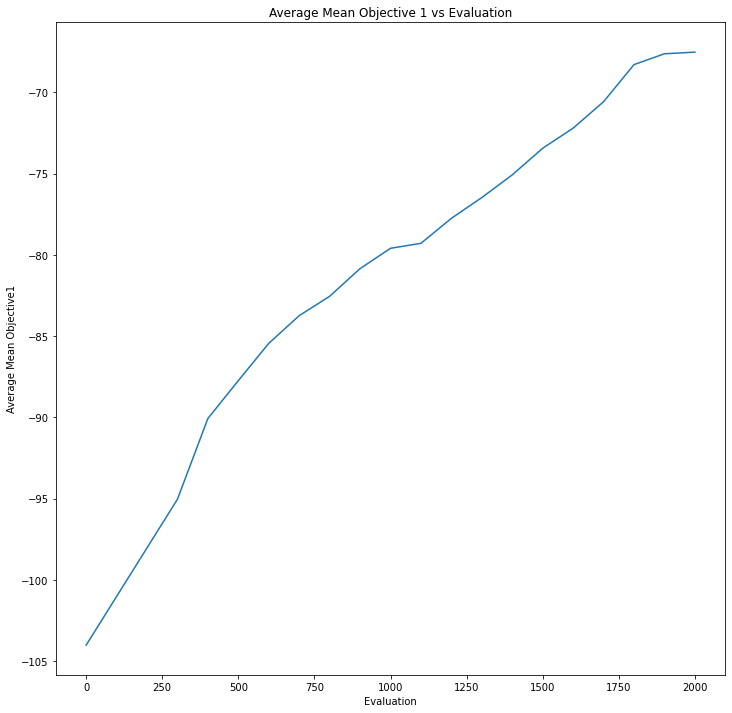

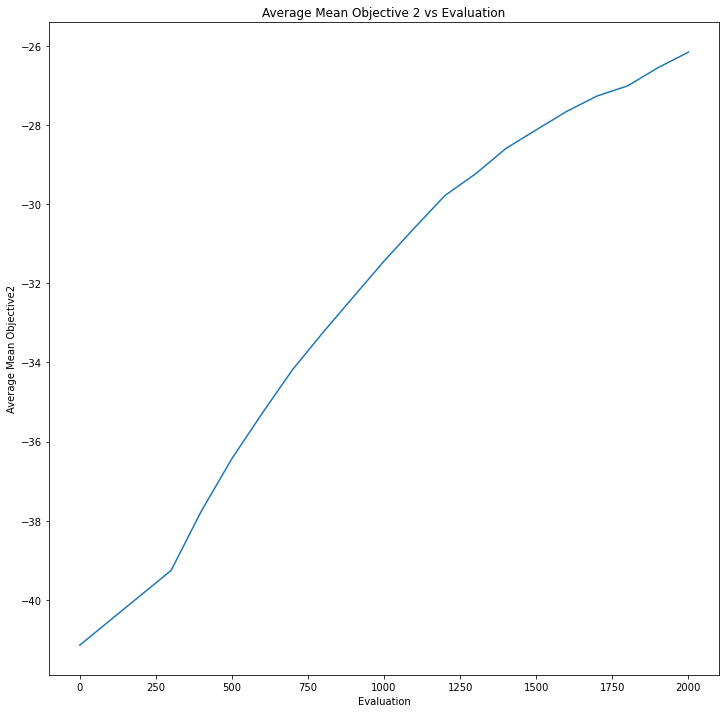

In [179]:
import matplotlib.pyplot as plt
  # plot Avg max vs eval and save it

for i in range(objCount):
    plt.plot(evalList, avgObjectives[i])
    plt.title('Average Mean Objective ' + str(i+1) + ' vs Evaluation')
    plt.xlabel('Evaluation')
    plt.ylabel('Average Mean Objective' + str(i+1))
    plt.savefig('data/meanAvgFitGraph' + str(i+1) + '.jpg')
    plt.show()

[-23.753333333333334, -21.92, -21.386666666666667, -20.506666666666668, -20.413333333333334, -20.240000000000002, -20.093333333333334, -20.16, -19.22, -18.85333333333333, -18.706666666666667, -18.806666666666665, -18.593333333333334, -17.74, -17.913333333333334, -17.64666666666667, -17.313333333333333, -17.04, -16.773333333333333]


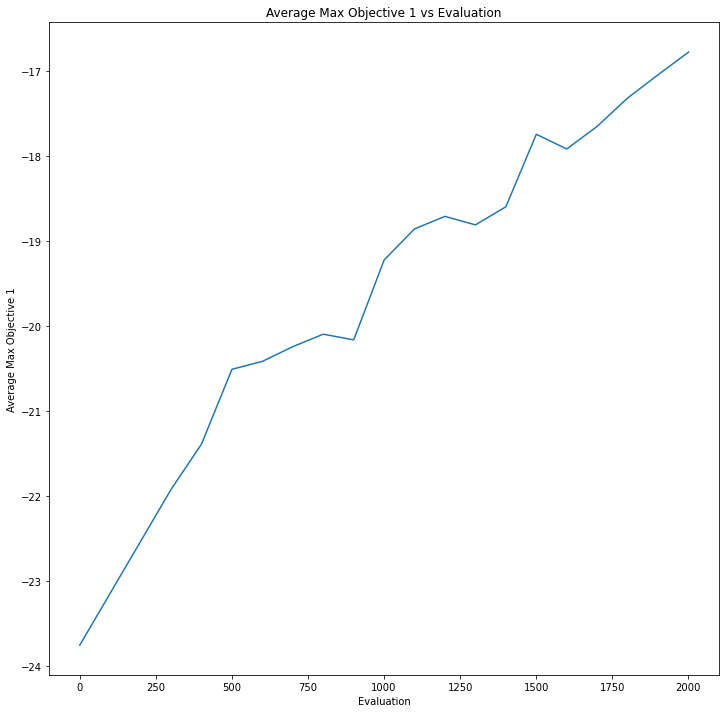

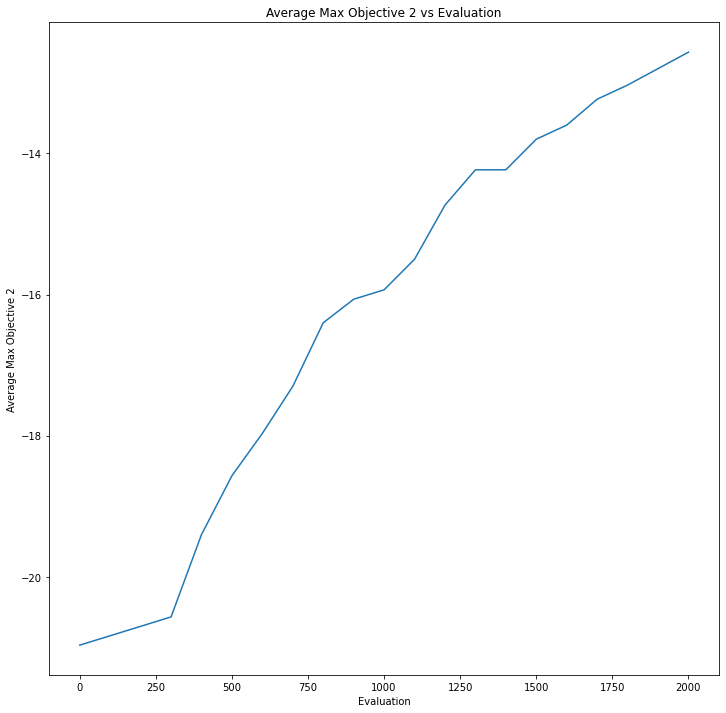

In [178]:
print(maxObjectives[0])
for i in range(objCount):
    plt.plot(evalList, maxObjectives[i])
    plt.title('Average Max Objective ' + str(i+1) + ' vs Evaluation')
    plt.xlabel('Evaluation')
    plt.ylabel('Average Max Objective ' + str(i+1))
    plt.savefig('data/meanMaxFitGraph' + str(i+1) + '.jpg')
    plt.show()# plot Avg avg vs eval and save it

In [171]:
#sort by magnitude to the next point so the plot doesnt look too stupid
objectiveList = [individual.objectives for individual in bestPareto]
objectiveList.sort(key = lambda p : (p[0]) ** 2 + (p[1]) ** 2)
sortedObjList = []
for i in range(0, len(objectiveList), 2):
    sortedByCurrentMagnitude = objectiveList.copy()
    sortedByCurrentMagnitude.sort(key = lambda p : (p[0] - objectiveList[i][0]) ** 2 + (p[1] - objectiveList[i][1]) ** 2)
    
    #find the closest point not already in sorted objective lsist, I think it should always be point 1 since there technically should only ever be two points that are closest to each other, but I put it in a for loop just in case
    for i in range(2):
        for objectives in sortedByCurrentMagnitude:
            if(objectives not in sortedObjList):
                sortedObjList.append(objectives)
print(sortedObjList, objectiveList)

[[-11.2, -22], [-13.4, -21], [-20, -17], [-30, -15], [-38, -13], [-39.2, -12], [-54.4, -11]] [[-11.2, -22], [-13.4, -21], [-20, -17], [-30, -15], [-38, -13], [-39.2, -12], [-54.4, -11]]


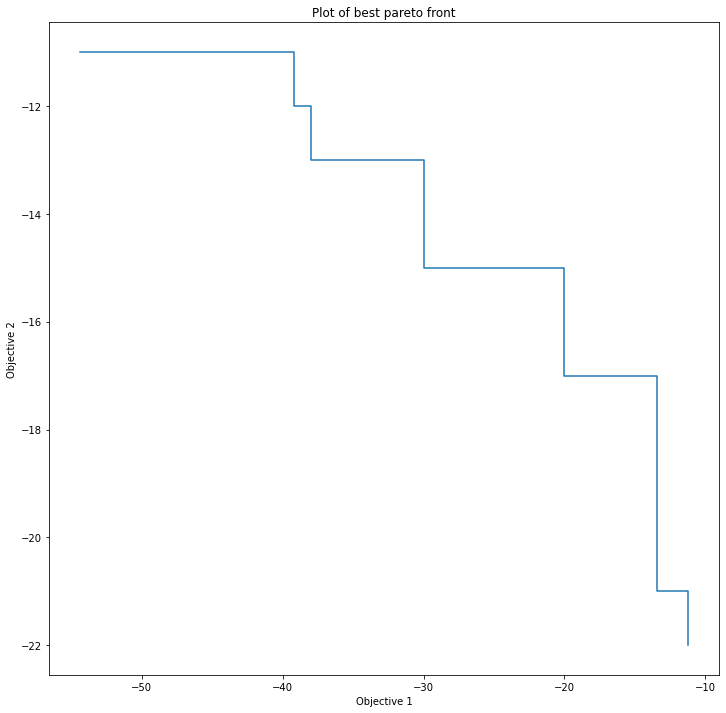

In [172]:
plt.step([objective[0] for objective in sortedObjList], [objective[1] for objective in sortedObjList])

plt.title('Plot of best pareto front')
plt.xlabel('Objective 1')
plt.ylabel('Objective 2')
plt.savefig('data/bestPareto.jpg')
plt.show()

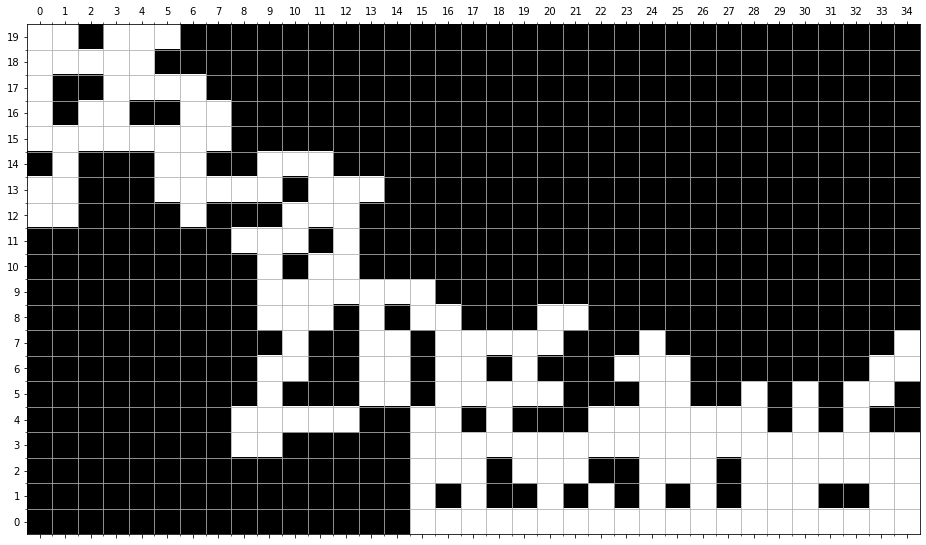

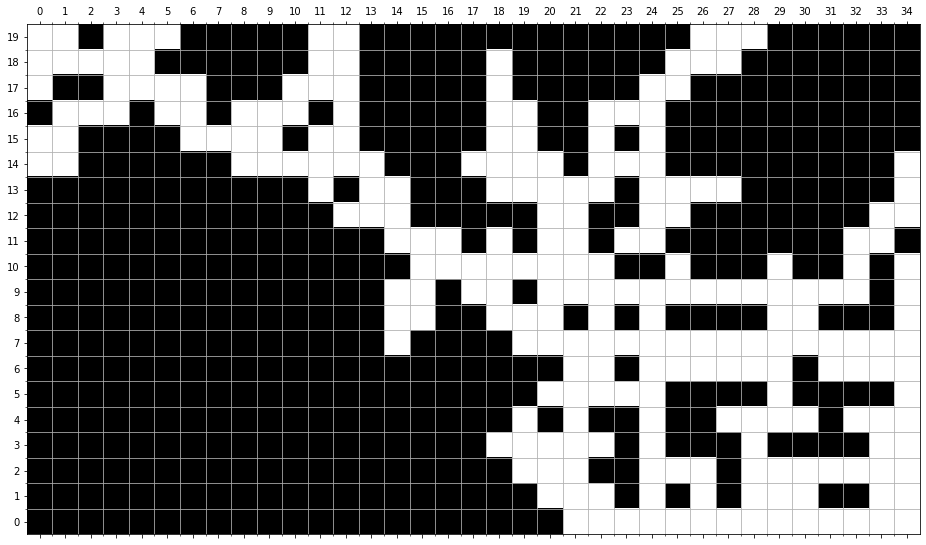

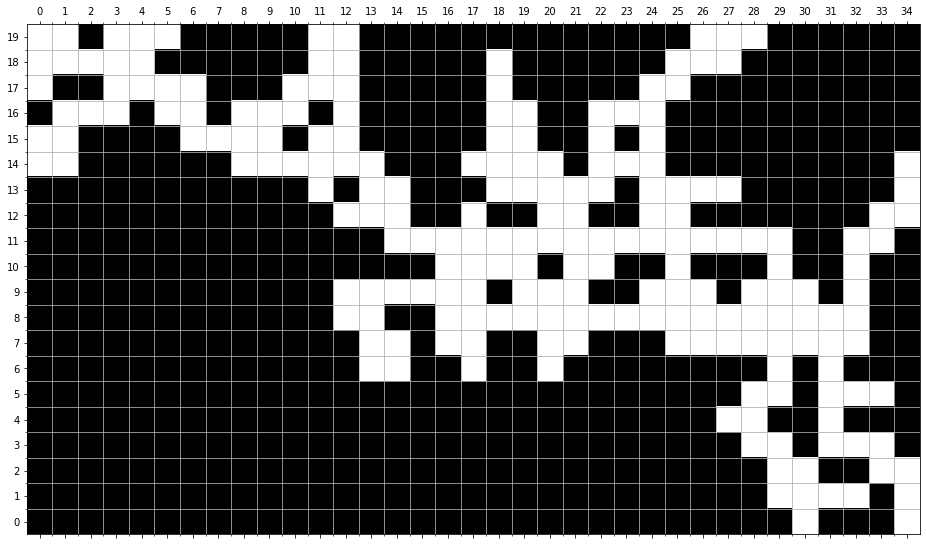

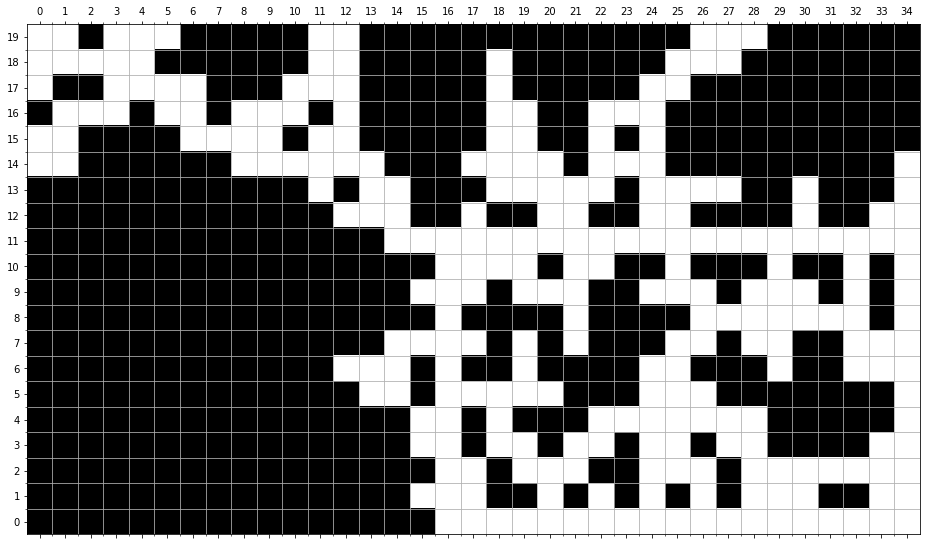

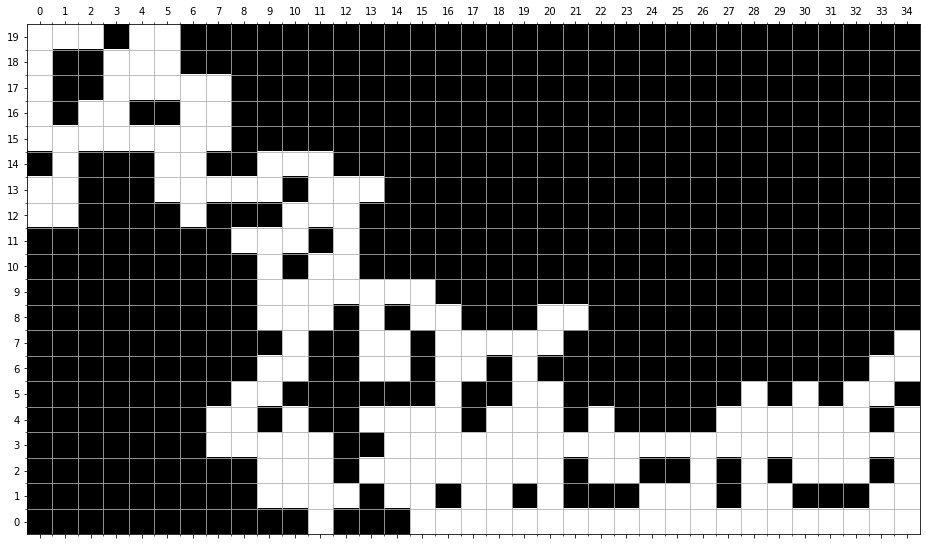

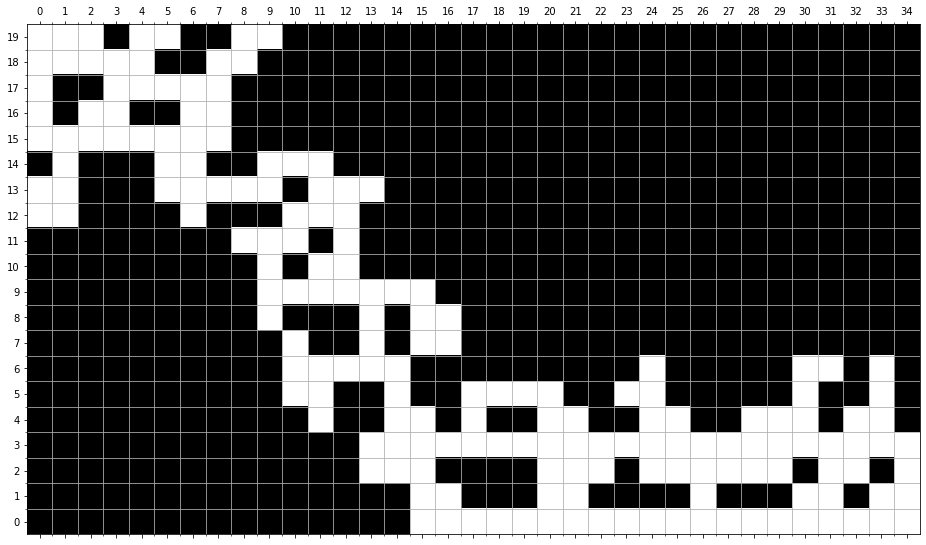

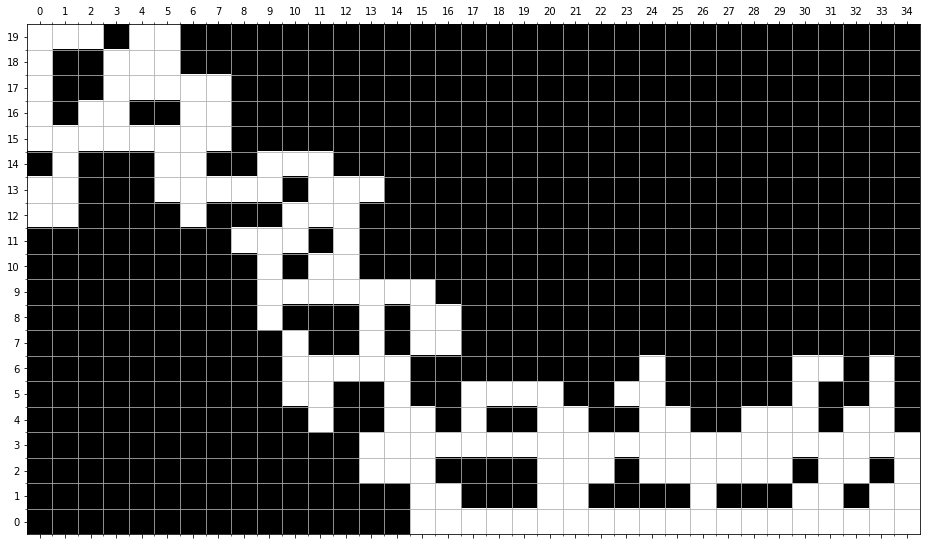

In [173]:
i = 0
for individual in bestPareto:
    repaired_map, _ = repair_map(translate_gene(individual.gene, config['fitness_kwargs']['height'], config['fitness_kwargs']['width']))
    plotMap(repaired_map, i)
    i+=1